In [22]:
import numpy as np
import pandas as pd

import pmdarima as pm
from statsmodels.tsa.api import ExponentialSmoothing
#from neuralprophet import NeuralProphet

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, PowerTransformer
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Statistics
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from pmdarima import auto_arima

# Graph
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import pandas_datareader as pdr
import datetime

from bs4 import BeautifulSoup

import sys
import quandl
import logging

from fredapi import Fred
fred = Fred(api_key='c0a3f23bdd23a65e6546b6d0e5f4d4a5')


sk.set_config(display='diagram')


# Warnings
import warnings
#warnings.filterwarnings('ignore')

# Loggers
import logging
logging.getLogger().setLevel(logging.ERROR)

# Functions

# Load Data

In [23]:
#  Set start date
start_date = datetime.date(2010, 1, 1)
start_date_str = datetime.datetime.strftime(start_date, "%Y-%m-%d")

#  Federal Reserve Economic Data Service
data_source = 'fred'
treasury_yield_code = 'DGS10' #  10-year Treasury Rate
unemployment_rate_code = 'UNRATE'
gdp_code = 'GDPC1'
mortgage_code = 'MORTGAGE30US'
snp_code = 'SP500'
personal_savings_rate_code = 'PSAVERT'
cpi_series = 'CPIAUCSL'
ff_rate_code = 'EFFR'

#  Fetch data
treasury_yield_df = pdr.DataReader(treasury_yield_code, data_source, start_date)
unemployment_rate_df = pdr.DataReader(unemployment_rate_code, data_source, start_date)
mortgate_data_df = pdr.DataReader(mortgage_code, data_source, start_date)
snp_data_df = pdr.DataReader(snp_code, data_source, start_date)
savings_df = pdr.DataReader(personal_savings_rate_code, data_source, start_date)
cpi_df = pdr.DataReader(cpi_series, data_source, start_date)
ff_rate_df = pdr.DataReader(ff_rate_code, data_source, start_date)

## Create DataFrame

In [24]:
df = pd.concat([treasury_yield_df,mortgate_data_df,snp_data_df,savings_df,unemployment_rate_df,cpi_df, ff_rate_df], axis=1)
df.sort_index(inplace=True)
df

,DGS10,MORTGAGE30US,SP500,PSAVERT,UNRATE,CPIAUCSL,EFFR
DATE,,,,,,,
2010-01-01,NaN,NaN,NaN,5.9,9.8,217.488,NaN
2010-01-04,3.85,NaN,NaN,NaN,NaN,NaN,0.12
2010-01-05,3.77,NaN,NaN,NaN,NaN,NaN,0.12
2010-01-06,3.85,NaN,NaN,NaN,NaN,NaN,0.12
2010-01-07,3.85,5.09,NaN,NaN,NaN,NaN,0.10
...,...,...,...,...,...,...,...
2023-07-18,3.80,NaN,4554.98,NaN,NaN,NaN,5.08
2023-07-19,3.75,NaN,4565.72,NaN,NaN,NaN,5.08
2023-07-20,3.85,6.78,4534.87,NaN,NaN,NaN,5.08


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3582 entries, 2010-01-01 to 2023-07-24
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DGS10         3392 non-null   float64
 1   MORTGAGE30US  707 non-null    float64
 2   SP500         2516 non-null   float64
 3   PSAVERT       161 non-null    float64
 4   UNRATE        162 non-null    float64
 5   CPIAUCSL      162 non-null    float64
 6   EFFR          3407 non-null   float64
dtypes: float64(7)
memory usage: 223.9 KB


In [26]:
df.isnull().sum() / len(df)

DGS10           0.053043
MORTGAGE30US    0.802624
SP500           0.297599
PSAVERT         0.955053
UNRATE          0.954774
CPIAUCSL        0.954774
EFFR            0.048855
dtype: float64

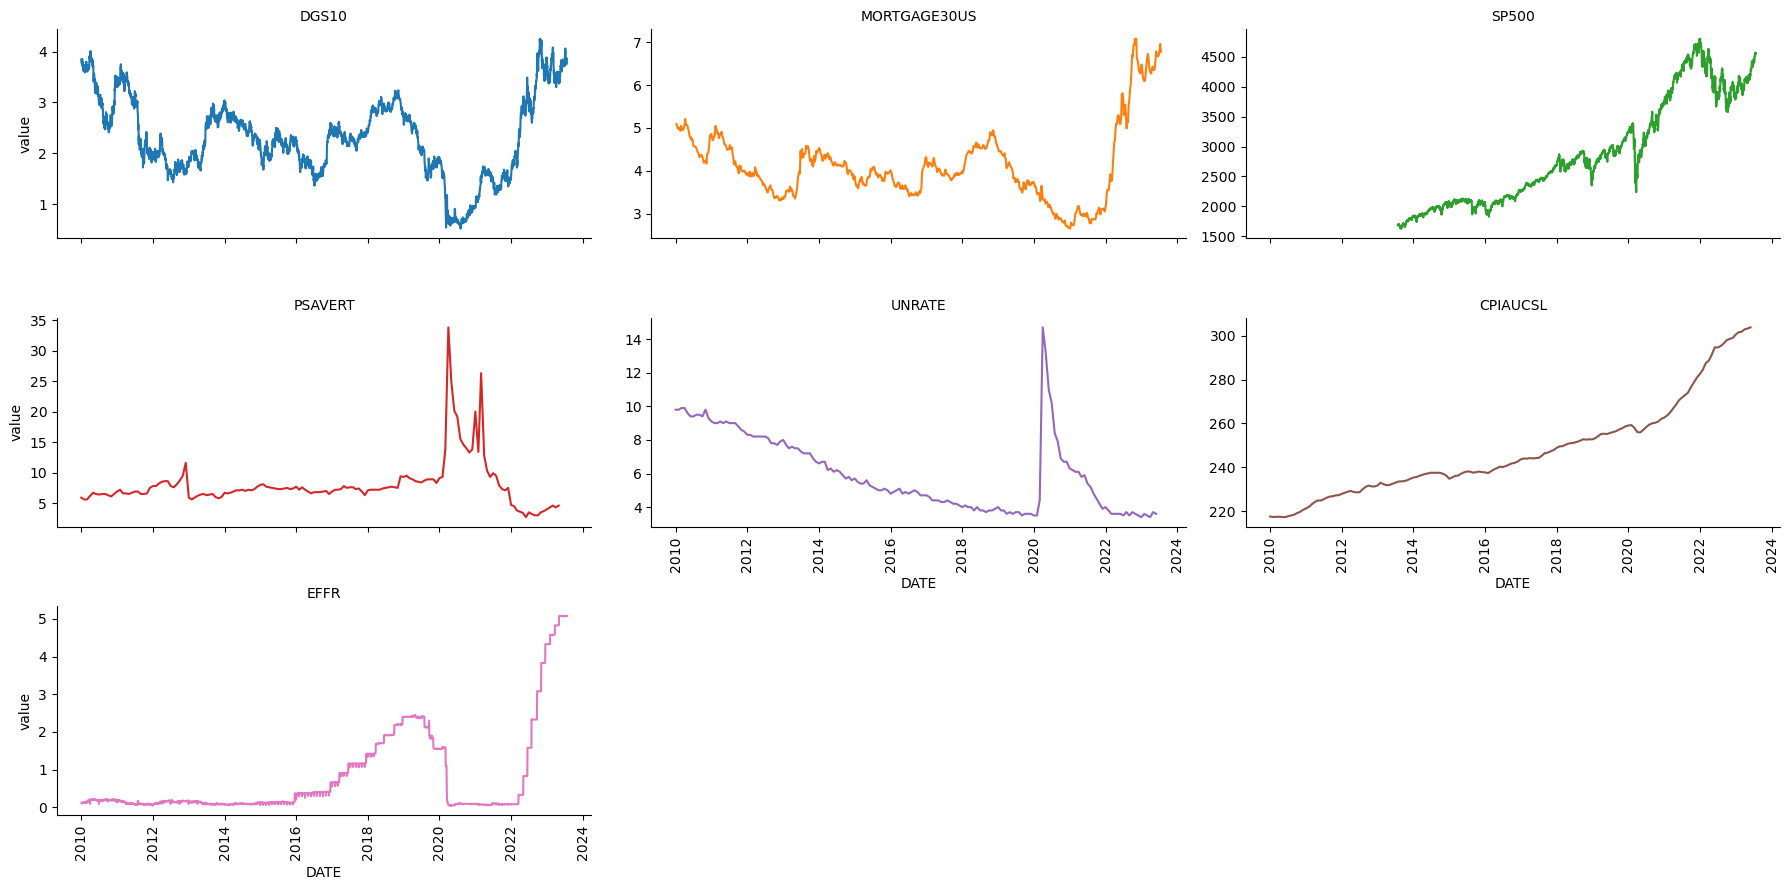

In [27]:
long_df = df.copy()
long_df.reset_index(inplace=True)

long_df = long_df.melt(id_vars=['DATE'])


# Graph
g = sns.FacetGrid(long_df, col='variable', hue='variable',
                  height=3, aspect=2,col_wrap=3, sharey=False)

g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.tick_params(axis='x', labelrotation=90) 
g.tight_layout()
g.map_dataframe(sns.lineplot, y="value", x="DATE")

plt.show()

## Fill Data

In [28]:
df = df.resample('MS').max()
df.asfreq('1M')

#df = df.asfreq(freq='1D', how='start', method='ffill', fill_value=0)
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)
df


,DGS10,MORTGAGE30US,SP500,PSAVERT,UNRATE,CPIAUCSL,EFFR
DATE,,,,,,,
2010-01-01,3.85,5.09,1691.65,5.9,9.8,217.488,0.13
2010-02-01,3.80,5.05,1691.65,5.6,9.8,217.281,0.14
2010-03-01,3.91,4.99,1691.65,5.6,9.9,217.353,0.20
2010-04-01,4.01,5.21,1691.65,6.2,9.9,217.403,0.22
2010-05-01,3.72,5.00,1691.65,6.7,9.6,217.290,0.21
...,...,...,...,...,...,...,...
2023-03-01,4.08,6.73,4109.31,4.6,3.5,301.808,4.83
2023-04-01,3.60,6.43,4169.48,4.3,3.4,302.918,4.83
2023-05-01,3.83,6.57,4205.52,4.6,3.7,303.294,5.08


In [29]:
df.isnull().sum() / len(df)

DGS10           0.0
MORTGAGE30US    0.0
SP500           0.0
PSAVERT         0.0
UNRATE          0.0
CPIAUCSL        0.0
EFFR            0.0
dtype: float64

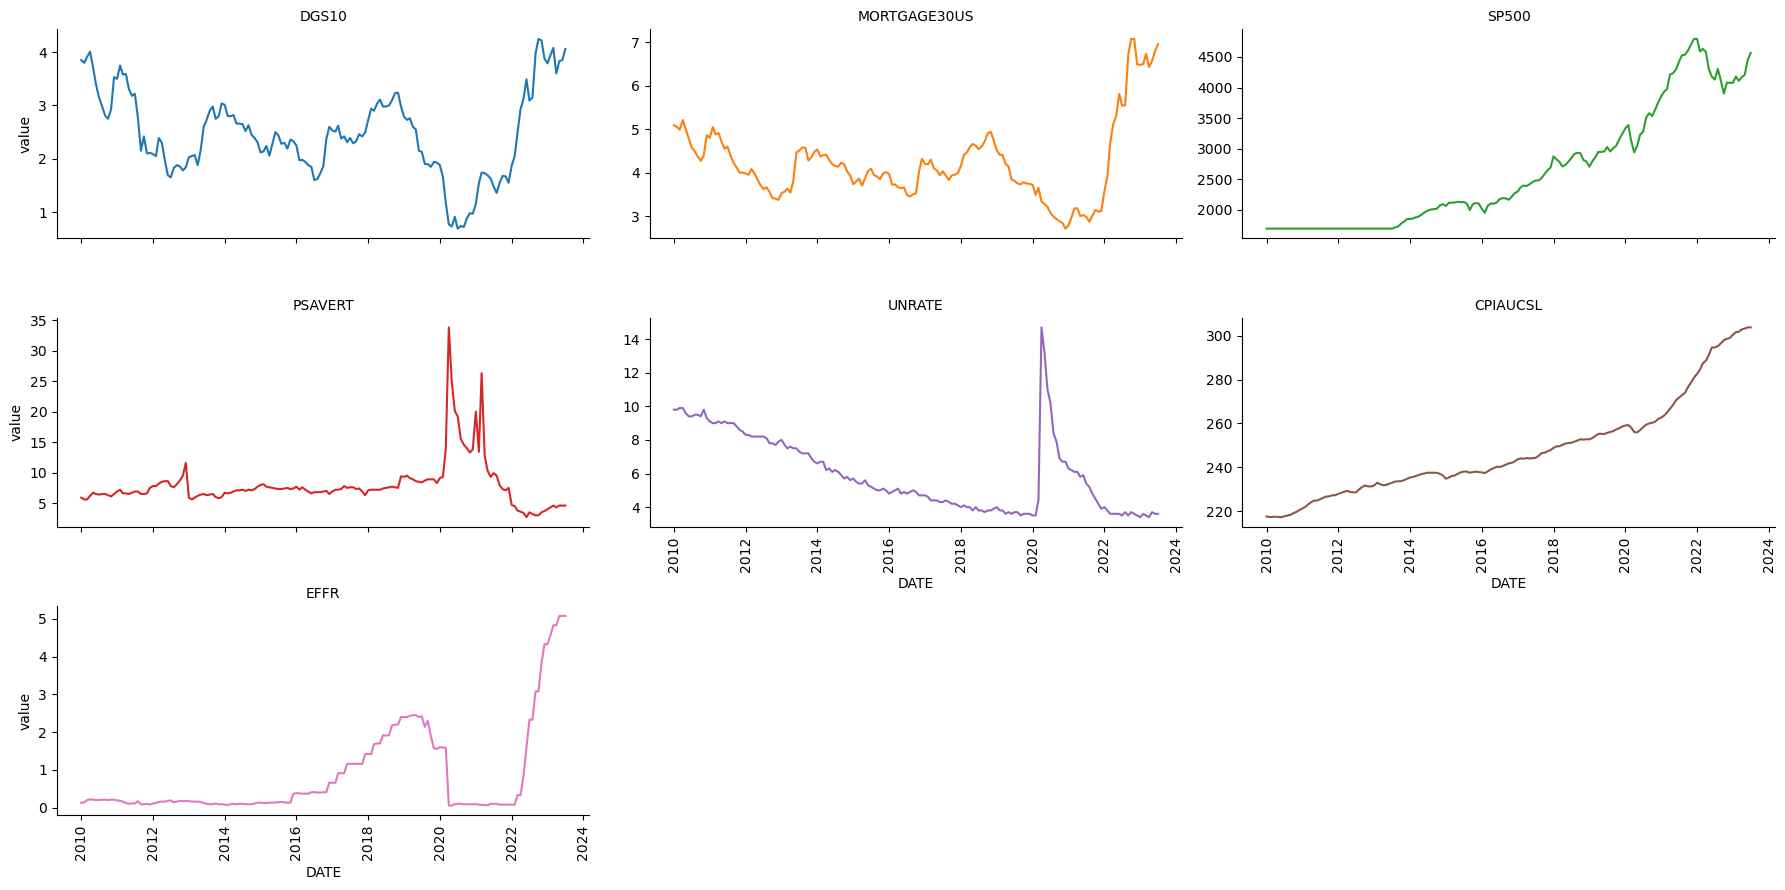

In [30]:
long_df = df.copy()
long_df.reset_index(inplace=True)

long_df = long_df.melt(id_vars=['DATE'])


# Graph
g = sns.FacetGrid(long_df, col='variable', hue='variable',
                  height=3, aspect=2,col_wrap=3, sharey=False)

g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.tick_params(axis='x', labelrotation=90) 
g.tight_layout()
g.map_dataframe(sns.lineplot, y="value", x="DATE")

plt.show()

<Axes: >

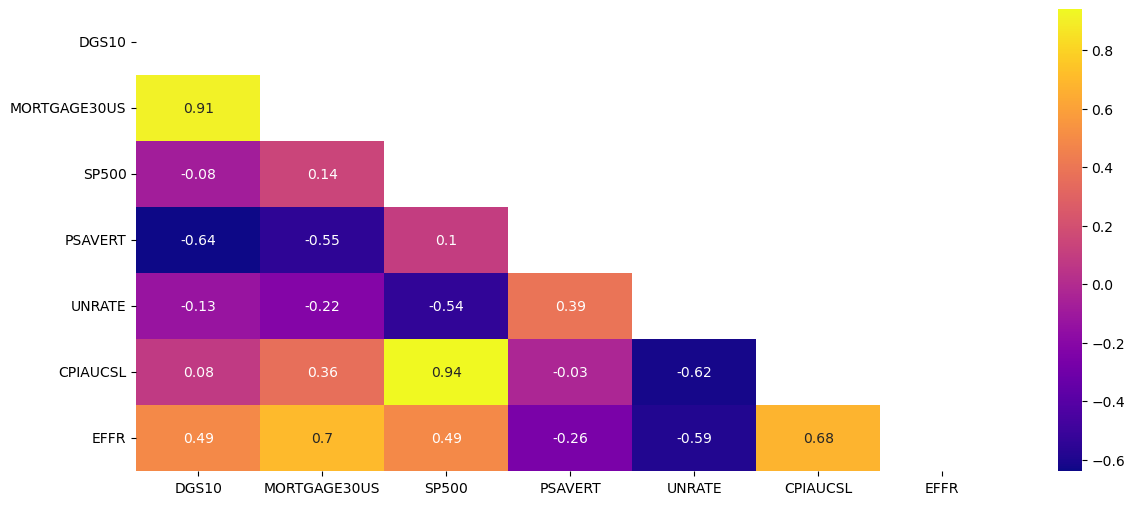

In [31]:
plt.figure(figsize=(14,6))
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.corr().round(2), annot=True, mask=mask, cmap="plasma")

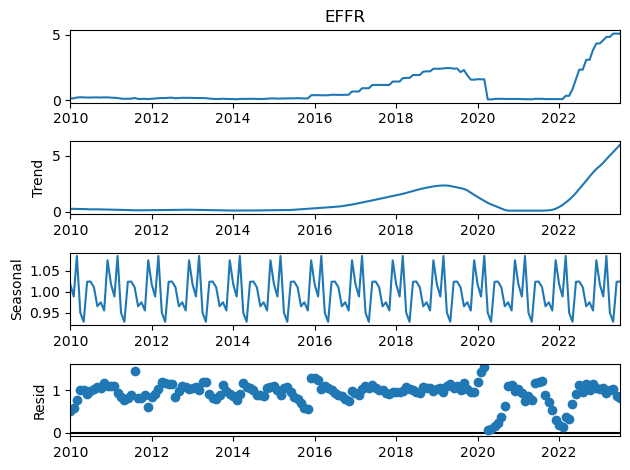

In [32]:
decomposition = sm.tsa.seasonal_decompose(df['EFFR'], model='multiplicative', 
                            extrapolate_trend='freq') #additive or multiplicative is data specific
fig = decomposition.plot()
plt.show()

# Test Train Split

## Train Data

In [33]:
splt_index = round(df.shape[0] * 0.8)
train_df = df[:splt_index].copy()
train_df = train_df.asfreq(freq='1M', how='start', method='ffill', fill_value=0)
train_df.fillna(method='ffill', inplace=True)

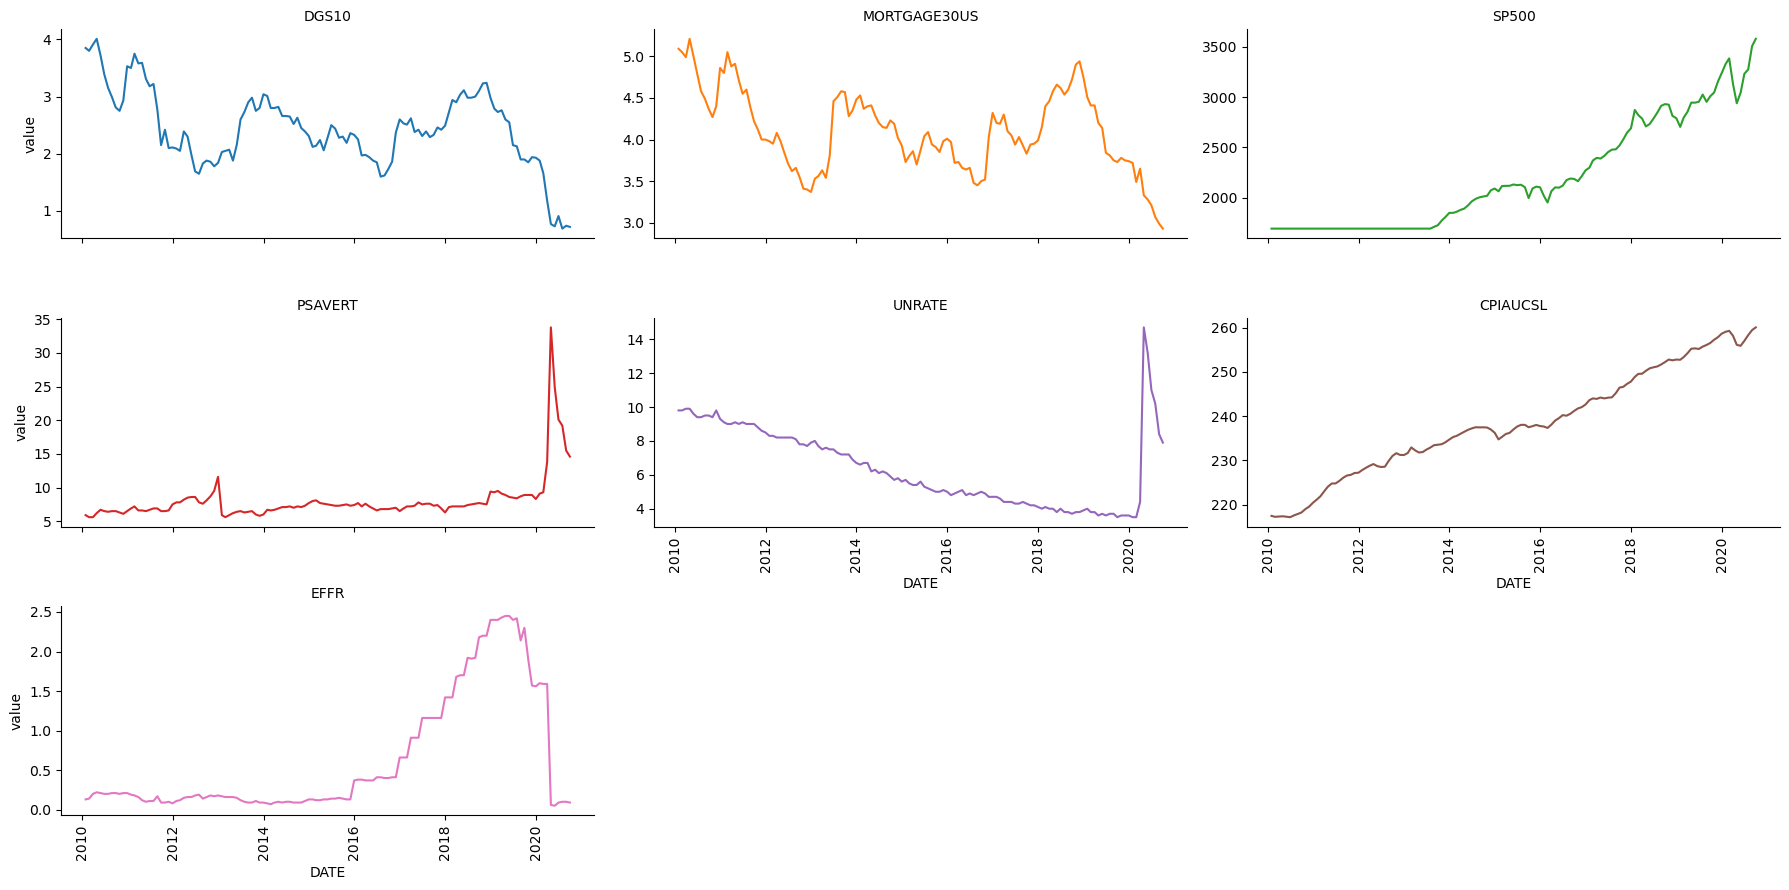

In [34]:
long_df = train_df.copy()
long_df.reset_index(inplace=True)

long_df = long_df.melt(id_vars=['DATE'])


# Graph
g = sns.FacetGrid(long_df, col='variable', hue='variable',
                  height=3, aspect=2,col_wrap=3, sharey=False)

g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.tick_params(axis='x', labelrotation=90) 
g.tight_layout()
g.map_dataframe(sns.lineplot, y="value", x="DATE")

plt.show()

## Test Data

In [35]:
test_df = df[splt_index:].copy()
test_df = test_df.asfreq(freq='1M', how='start', method='ffill', fill_value=0)
test_df.fillna(method='ffill', inplace=True)

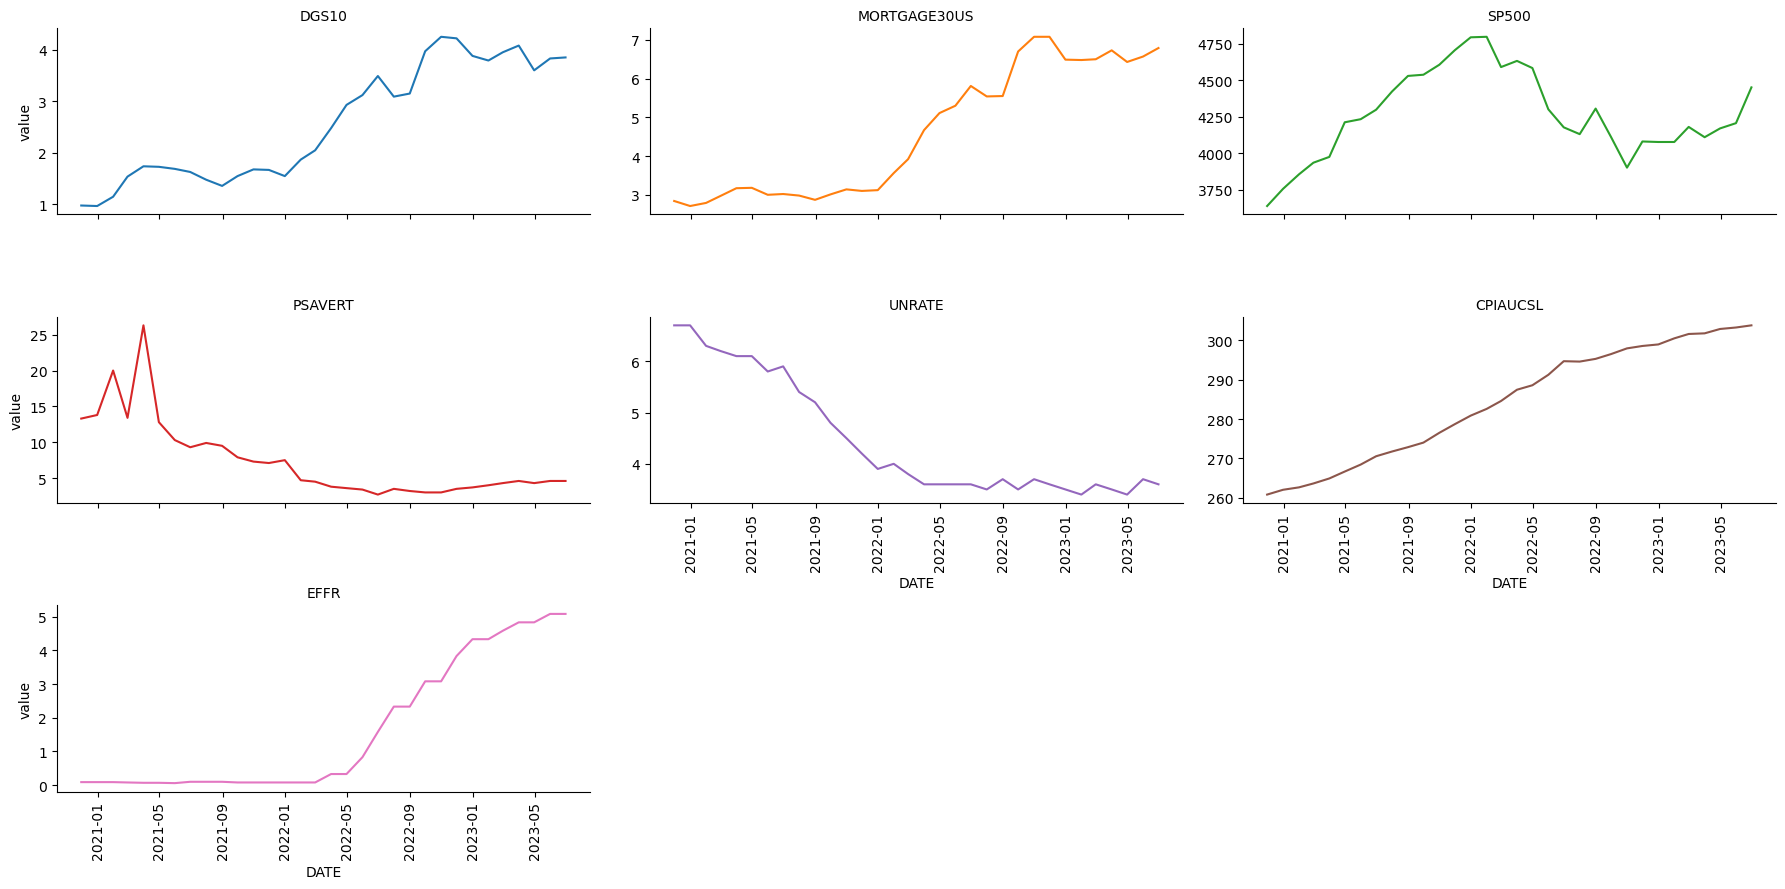

In [36]:
long_df = test_df.copy()
long_df.reset_index(inplace=True)

long_df = long_df.melt(id_vars=['DATE'])


# Graph
g = sns.FacetGrid(long_df, col='variable', hue='variable',
                  height=3, aspect=2,col_wrap=3, sharey=False)

g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.tick_params(axis='x', labelrotation=90) 
g.tight_layout()
g.map_dataframe(sns.lineplot, y="value", x="DATE")

plt.show()

# tsa.SARIMAX

In [84]:
exog_lst = ['DGS10', 'MORTGAGE30US', 'SP500', 'PSAVERT', 'UNRATE', 'CPIAUCSL']

In [85]:
model = sm.tsa.SARIMAX(train_df['EFFR'], exog=train_df[exog_lst])

In [88]:
result_model = model.fit(disp=False)

In [89]:
print(result_model.summary())

                               SARIMAX Results                                
Dep. Variable:                   EFFR   No. Observations:                  129
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 118.689
Date:                Tue, 25 Jul 2023   AIC                           -221.379
Time:                        18:21:27   BIC                           -198.500
Sample:                    01-31-2010   HQIC                          -212.083
                         - 09-30-2020                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
DGS10           -0.1835      0.096     -1.918      0.055      -0.371       0.004
MORTGAGE30US     0.2805      0.112      2.502      0.012       0.061       0.500
SP500           -0.0001      0.000     -0.64

# Training Predict 

In [97]:
train_result = result_model.get_prediction(start=-len(train_df), dynamic=True)

In [98]:
train_pred = train_result.summary_frame()
train_pred

EFFR,mean,mean_se,mean_ci_lower,mean_ci_upper
DATE,,,,
2010-01-31,0.043377,0.335257,-0.613714,0.700469
2010-02-28,0.038181,0.335257,-0.618910,0.695273
2010-03-31,-0.013613,0.335257,-0.670704,0.643479
2010-04-30,0.034443,0.335257,-0.622648,0.691535
2010-05-31,0.077274,0.335257,-0.579817,0.734366
...,...,...,...,...
2020-05-31,-0.255457,0.335257,-0.912549,0.401634
2020-06-30,-0.029182,0.335257,-0.686274,0.627909
2020-07-31,0.086502,0.335257,-0.570590,0.743593


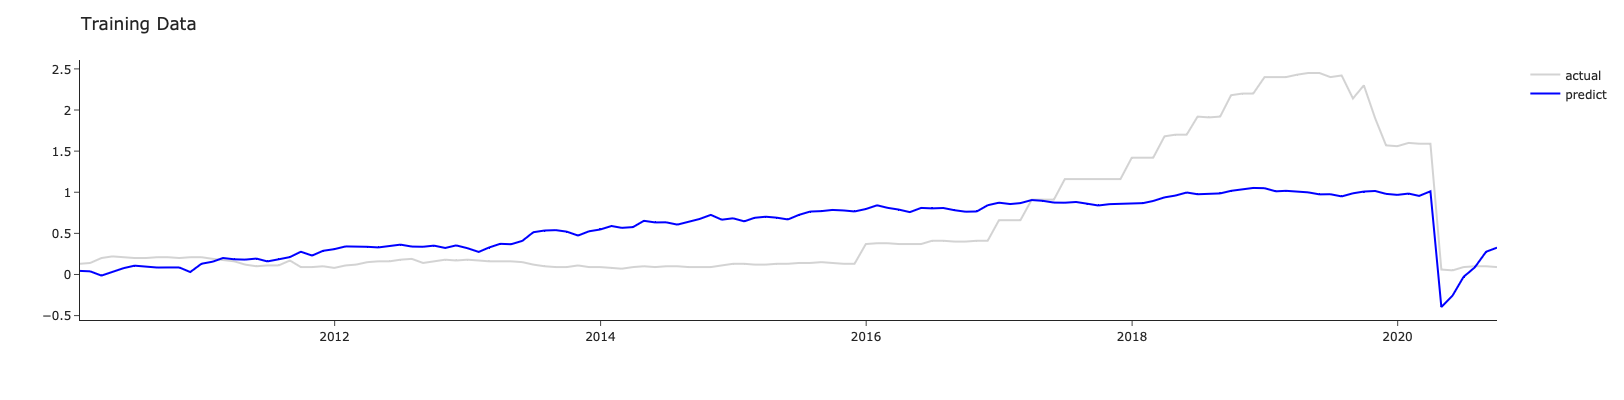

In [102]:
fig = px.line(height=400)
fig.add_scatter(y=train_df['EFFR'], x=train_df.index,
                marker=dict(size=20, color="lightgray"), name='actual')
fig.add_scatter(y=train_pred['mean'], x=train_pred.index,
                marker=dict(size=20, color="blue"), name='predict')
fig.update_layout(template="simple_white", title="Training Data")
fig.show()

## Testing Predictions

In [120]:
s_idx = len(train_df)
e_idx = s_idx + len(test_df) - 1

In [121]:
test_result = result_model.get_prediction(start=s_idx, end=e_idx, exog=test_df[exog_lst], dynamic=True)

In [122]:
test_pred = test_result.summary_frame()
test_pred

EFFR,mean,mean_se,mean_ci_lower,mean_ci_upper
2020-10-31,0.194937,0.095451,0.007855,0.382018
2020-11-30,0.164771,0.132225,-0.094385,0.423927
2020-12-31,0.260674,0.158673,-0.050320,0.571667
2021-01-31,0.209004,0.179575,-0.142957,0.560965
2021-02-28,0.348833,0.196836,-0.036957,0.734624
2021-03-31,0.240261,0.211458,-0.174189,0.654712
2021-04-30,0.236663,0.224056,-0.202478,0.675804
2021-05-31,0.239595,0.235038,-0.221070,0.700260
2021-06-30,0.333286,0.244695,-0.146307,0.812880
2021-07-31,0.350540,0.253245,-0.145811,0.846891


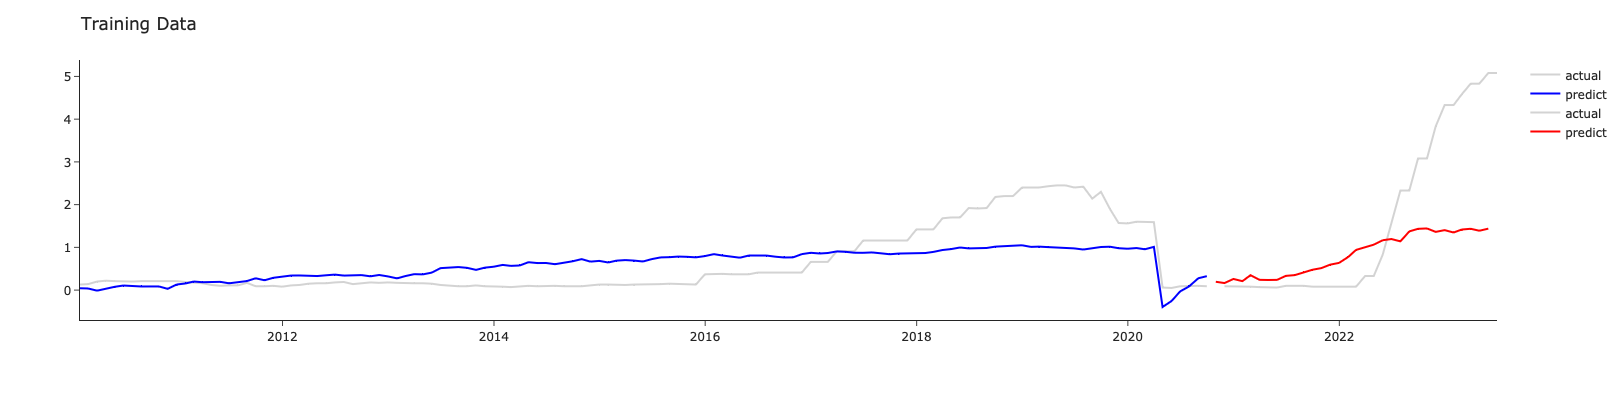

In [123]:
fig = px.line(height=400)
fig.add_scatter(y=train_df['EFFR'], x=train_df.index,
                marker=dict(size=20, color="lightgray"), name='actual')
fig.add_scatter(y=train_pred['mean'], x=train_pred.index,
                marker=dict(size=20, color="blue"), name='predict')
fig.add_scatter(y=test_df['EFFR'], x=test_df.index,
                marker=dict(size=20, color="lightgray"), name='actual')
fig.add_scatter(y=test_pred['mean'], x=test_pred.index,
                marker=dict(size=20, color="red"), name='predict')
fig.update_layout(template="simple_white", title="Training Data")
fig.show()

# SARIMA

In [37]:
train_df['EFFR']

DATE
2010-01-31    0.13
2010-02-28    0.14
2010-03-31    0.20
2010-04-30    0.22
2010-05-31    0.21
              ... 
2020-05-31    0.05
2020-06-30    0.09
2020-07-31    0.10
2020-08-31    0.10
2020-09-30    0.09
Freq: M, Name: EFFR, Length: 129, dtype: float64

In [38]:
# Auto-ARIMA training time series with seasonality
sarima = auto_arima(train_df['EFFR'], stepwise=True,seasonal=True, trace=True)
sarima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-96.405, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-101.378, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-99.404, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-99.404, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-103.378, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-97.404, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.145 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  129
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  52.689
Date:                Tue, 25 Jul 2023   AIC                           -103.378
Time:                        17:44:08   BIC                           -100.526
Sample:                    01-31-2010   HQIC                          -102.219
                         - 09-30-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0257      0.001     45.507      0.000       0.025       0.027
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             21914.46
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):             121.66   Skew:                            -6.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        65.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

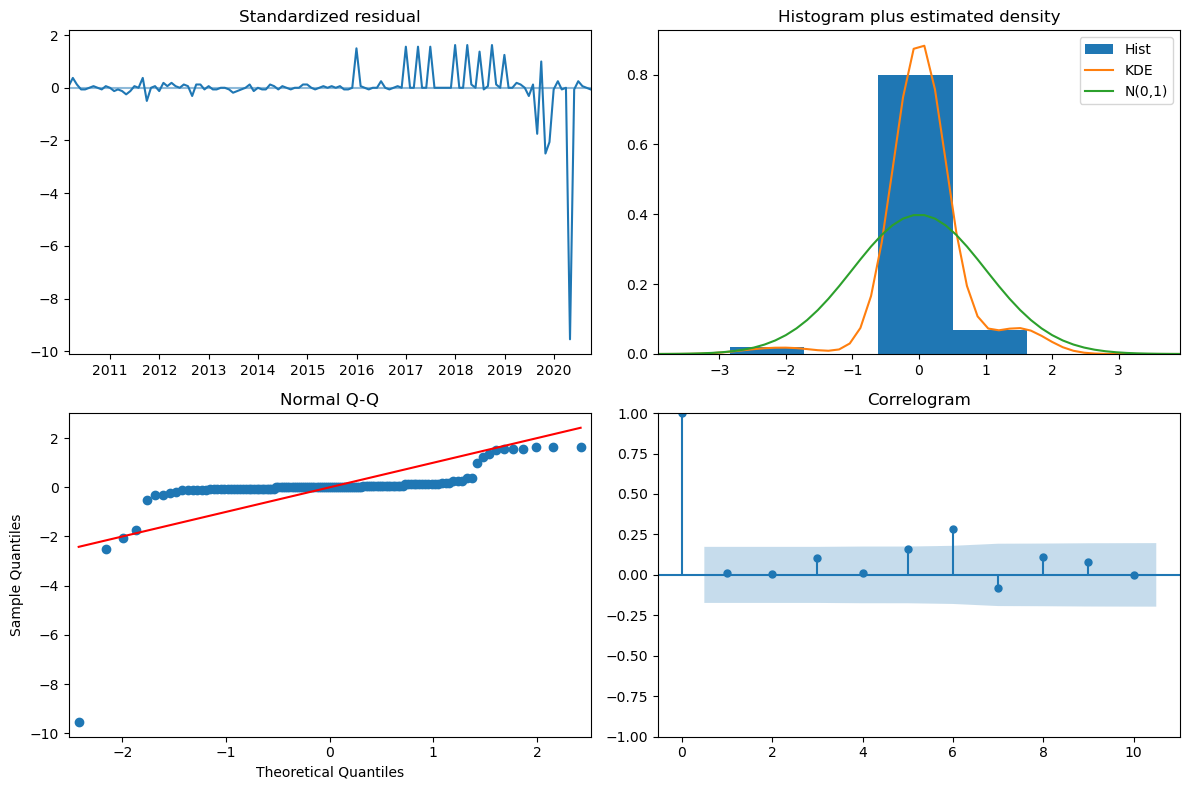

In [39]:
# Residual Plots
sarima.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

In [65]:
sarima_fit = sarima.fit(y=train_df['EFFR'], exogenous=train_df[exog_lst], seasonal=True, trace=True)
sarima_fit

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [66]:
# Residual analysis
residuals = pd.Series(sarima_fit.resid())
mean_residuals = np.mean(residuals)
print(f'Mean of Residuals = {mean_residuals}')
print(f'Skewness: {round(residuals.skew(), 2)}')

Mean of Residuals = 0.000697674417254803
Skewness: -6.83


In [67]:
# Forecasting with the best model
train_forecast = sarima_fit.predict(len(train_df))
sarima_rmse = mean_squared_error(train_df['EFFR'], train_forecast, squared=False)
print(f'Root Mean Square Error = {sarima_rmse}')

Root Mean Square Error = 0.9417808464768742


In [68]:
train_forecast

2020-10-31    0.09
2020-11-30    0.09
2020-12-31    0.09
2021-01-31    0.09
2021-02-28    0.09
              ... 
2031-02-28    0.09
2031-03-31    0.09
2031-04-30    0.09
2031-05-31    0.09
2031-06-30    0.09
Freq: M, Length: 129, dtype: float64

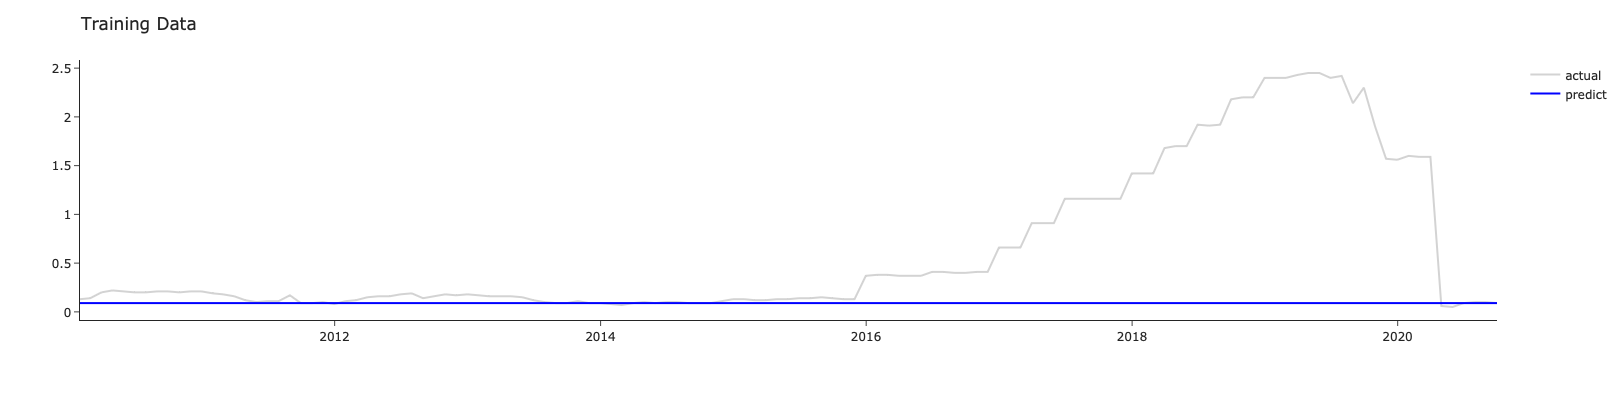

In [69]:
fig = px.line(height=400)
fig.add_scatter(y=train_df['EFFR'], x=train_df.index,
                marker=dict(size=20, color="lightgray"), name='actual')
fig.add_scatter(y=train_forecast, x=train_df.index,
                marker=dict(size=20, color="blue"), name='predict')
fig.update_layout(template="simple_white", title="Training Data")
fig.show()

# SARIMA Exog

In [70]:
#exog_lst = ['DGS10', 'MORTGAGE30US', 'SP500', 'PSAVERT', 'UNRATE', 'CPIAUCSL']
exog_lst = [ 'UNRATE']

In [71]:
# Auto-ARIMA training time series with seasonality
sarima1 = auto_arima(train_df['EFFR'], exogenous=train_df[exog_lst], stepwise=True,seasonal=True, trace=True)
sarima1.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-96.405, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-101.378, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-99.404, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-99.404, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-103.378, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-97.404, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.154 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  129
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  52.689
Date:                Tue, 25 Jul 2023   AIC                           -103.378
Time:                        18:02:19   BIC                           -100.526
Sample:                    01-31-2010   HQIC                          -102.219
                         - 09-30-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0257      0.001     45.507      0.000       0.025       0.027
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             21914.46
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):             121.66   Skew:                            -6.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        65.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [73]:
sarima1_fit = sarima1.fit(y=train_df['EFFR'], exogenous=train_df[exog_lst], seasonal=True, trace=True)
sarima1_fit

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [57]:
## Trainging Prediction

In [74]:
# Forecasting with the best model
train_forecast = sarima1_fit.predict(n_periods=len(train_df), exogenous=train_df[exog_lst], return_conf_int=True)
sarima_rmse = mean_squared_error(train_df['EFFR'], train_forecast[0], squared=False)
print(f'Root Mean Square Error = {sarima_rmse}')

Root Mean Square Error = 0.9417808464768742


In [75]:
train_pred = train_df.copy()
train_pred['EFFR_PRED'] = train_forecast[0].tolist()
train_pred

,DGS10,MORTGAGE30US,SP500,PSAVERT,UNRATE,CPIAUCSL,EFFR,EFFR_PRED
DATE,,,,,,,,
2010-01-31,3.85,5.09,1691.65,5.9,9.8,217.488,0.13,0.09
2010-02-28,3.80,5.05,1691.65,5.6,9.8,217.281,0.14,0.09
2010-03-31,3.91,4.99,1691.65,5.6,9.9,217.353,0.20,0.09
2010-04-30,4.01,5.21,1691.65,6.2,9.9,217.403,0.22,0.09
2010-05-31,3.72,5.00,1691.65,6.7,9.6,217.290,0.21,0.09
...,...,...,...,...,...,...,...,...
2020-05-31,0.73,3.28,3044.31,24.9,13.2,255.868,0.05,0.09
2020-06-30,0.91,3.21,3232.39,20.1,11.0,256.986,0.09,0.09
2020-07-31,0.69,3.07,3276.02,19.2,10.2,258.278,0.10,0.09


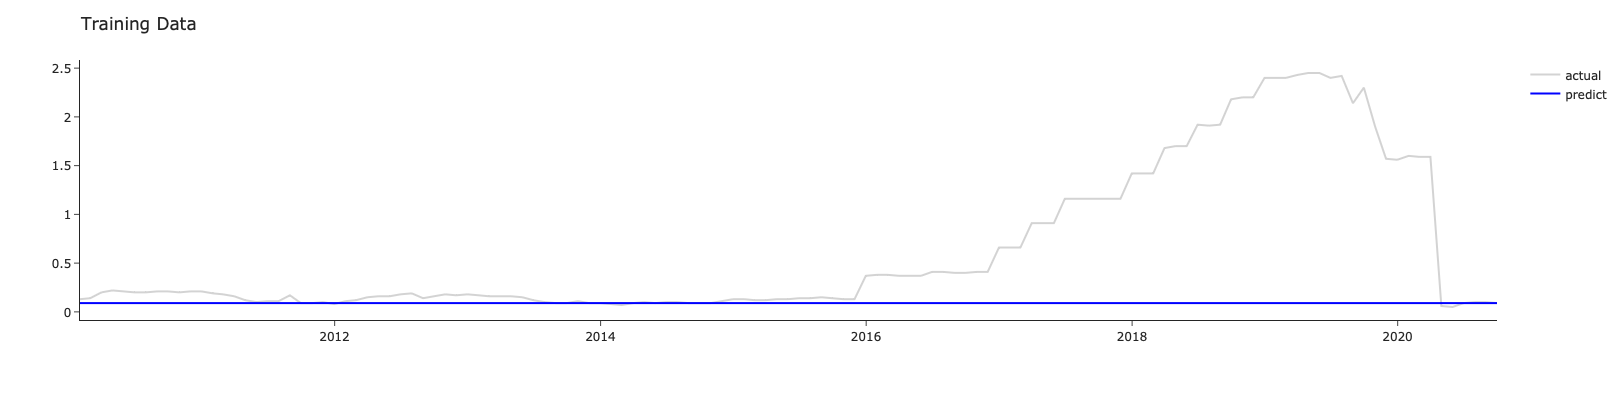

In [76]:
fig = px.line(height=400)
fig.add_scatter(y=train_pred['EFFR'], x=train_pred.index,
                marker=dict(size=20, color="lightgray"), name='actual')
fig.add_scatter(y=train_pred['EFFR_PRED'], x=train_pred.index,
                marker=dict(size=20, color="blue"), name='predict')
fig.update_layout(template="simple_white", title="Training Data")
fig.show()

2020-10-31    0.09
2020-11-30    0.09
2020-12-31    0.09
2021-01-31    0.09
2021-02-28    0.09
              ... 
2031-02-28    0.09
2031-03-31    0.09
2031-04-30    0.09
2031-05-31    0.09
2031-06-30    0.09
Freq: M, Length: 129, dtype: float64

## Testing Prediction

In [77]:
# Forecasting with the best model
test_forecast = sarima1_fit.predict(n_periods=len(test_df), exogenous=test_df[exog_lst], return_conf_int=True)
sarima_rmse = mean_squared_error(test_df['EFFR'], test_forecast[0], squared=False)
print(f'Root Mean Square Error = {sarima_rmse}')

Root Mean Square Error = 2.472595422830027


In [78]:
test_pred = test_df.copy()
test_pred['EFFR_PRED'] = test_forecast[0].tolist()
test_pred

,DGS10,MORTGAGE30US,SP500,PSAVERT,UNRATE,CPIAUCSL,EFFR,EFFR_PRED
DATE,,,,,,,,
2020-11-30,0.98,2.84,3638.35,13.3,6.7,260.813,0.09,0.09
2020-12-31,0.97,2.71,3756.07,13.8,6.7,262.035,0.09,0.09
2021-01-31,1.15,2.79,3855.36,20.0,6.3,262.650,0.09,0.09
2021-02-28,1.54,2.97,3934.83,13.4,6.2,263.638,0.08,0.09
2021-03-31,1.74,3.17,3974.54,26.3,6.1,264.914,0.07,0.09
2021-04-30,1.73,3.18,4211.47,12.8,6.1,266.670,0.07,0.09
2021-05-31,1.69,3.00,4232.60,10.3,5.8,268.444,0.06,0.09
2021-06-30,1.63,3.02,4297.50,9.3,5.9,270.559,0.10,0.09
2021-07-31,1.48,2.98,4422.30,9.9,5.4,271.764,0.10,0.09


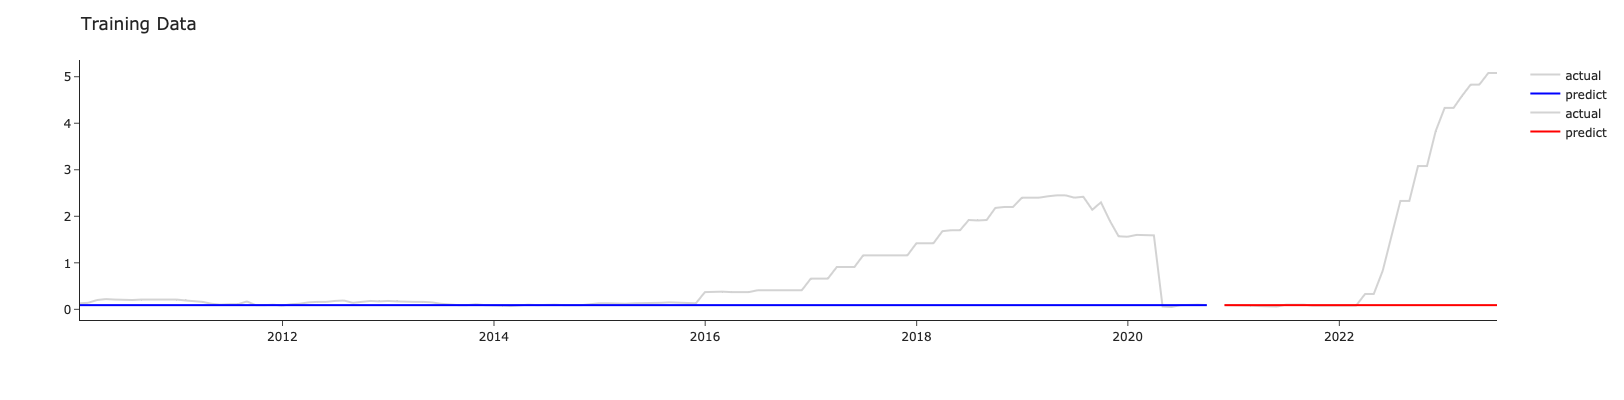

In [79]:
fig = px.line(height=400)
fig.add_scatter(y=train_pred['EFFR'], x=train_pred.index,
                marker=dict(size=20, color="lightgray"), name='actual')
fig.add_scatter(y=train_pred['EFFR_PRED'], x=train_pred.index,
                marker=dict(size=20, color="blue"), name='predict')
fig.add_scatter(y=test_pred['EFFR'], x=test_pred.index,
                marker=dict(size=20, color="lightgray"), name='actual')
fig.add_scatter(y=test_pred['EFFR_PRED'], x=test_pred.index,
                marker=dict(size=20, color="red"), name='predict')
fig.update_layout(template="simple_white", title="Training Data")
fig.show()